## Lab 4

Step 1: Data from unstructured websites

In [1]:
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup

url = "https://tastesbetterfromscratch.com/meal-plan-202/"
headers = {"User-Agent": "Mozilla/5.0", "Accept-Language": "en-US,en;q=0.9"}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.text, "html.parser")

days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
data = []
price_pattern = re.compile(r"\$\s*\d+(?:\.\d{2})?")

In [3]:
# asked chat for help with finding the tags
for day in days:
    tag = soup.find(lambda t: t and re.search(fr"\b{day}\b", t.get_text(strip=True), re.I))
    if not tag:
        continue

    a = tag.find_next("a", href=True)
    if not a:
        continue

    # look for a price near that link
    text = a.get_text(" ", strip=True) + " " + a.parent.get_text(" ", strip=True)
    price_match = price_pattern.search(text)
    price = price_match.group().replace(" ", "") if price_match else ""

    data.append({
        "Day of the Week": day,
        "Name of Recipe": a.get_text(strip=True),
        "Link to Recipe": a["href"],
        "Price of Recipe": price
    })

df = pd.DataFrame(data)
print(df)
df.to_csv("meal_plan_202.csv", index=False)

  Day of the Week              Name of Recipe  \
0          Monday             Skip to content   
1         Tuesday            Beef Noodle Soup   
2       Wednesday              Stuffed Shells   
3        Thursday  Vegetarian Stuffed Peppers   
4          Friday               Chicken Gyros   
5          Monday             Skip to content   
6         Tuesday            Beef Noodle Soup   
7       Wednesday              Stuffed Shells   
8        Thursday  Vegetarian Stuffed Peppers   
9          Friday               Chicken Gyros   

                                      Link to Recipe Price of Recipe  
0                                      #main-content          $10.82  
1  https://tastesbetterfromscratch.com/beef-noodl...          $29.29  
2  https://tastesbetterfromscratch.com/lasagna-st...          $12.30  
3  https://tastesbetterfromscratch.com/southwest-...          $19.60  
4  https://tastesbetterfromscratch.com/chicken-gy...          $21.22  
5                                 

Step 2: search for recipies that match the monday recipe

In [ ]:
import pandas as pd
import requests

# API setup
url = "https://tasty.p.rapidapi.com/recipes/list"
querystring = {"from":"0", "size":"20", "q":"chicken"}
headers = {
    "X-RapidAPI-Key": "e9dcf28121msh4fa502042ebfa40p10b903jsn80af2a0fe7f9",
    "X-RapidAPI-Host": "tasty.p.rapidapi.com"
}

# Make request
response = requests.get(url, headers=headers, params=querystring)
data = response.json()

# Extract recipe info
recipes = []
for recipe in data['results']:
    recipes.append({
        'Name': recipe['name'],
        'ID': recipe['id'],
        'Rating': recipe.get('user_ratings', {}).get('score', 'N/A')
    })

# Create DataFrame
monday_df = pd.DataFrame(recipes)
print(monday_df)
monday_df.to_csv('monday_recipes.csv', index=False)

                                        Name    ID    Rating
0             Low-Carb Avocado Chicken Salad  4704  0.917364
1                         Creamy Cajun Pasta  4870  0.961290
2                      Creamy Tuscan Chicken  1425  0.975316
3                          100-Layer Lasagna  3746  0.720117
4                 Creamy Chicken Penne Pasta    48  0.977389
5              3-Ingredient Teriyaki Chicken  1508  0.903752
6   Original Orange Chicken by Panda Express  3383  0.953639
7                Paprika Chicken & Rice Bake   746  0.974744
8                        Easy Butter Chicken   432  0.973755
9              One-Pot Garlic Parmesan Pasta  2932  0.951609
10        Crispy, Creamy Chicken Cordon Bleu  2437  0.953129
11                   One-Pot Chicken Alfredo   143  0.971715
12              One-Pot Chicken Fajita Pasta  3289  0.911847
13          Asparagus-Stuffed Chicken Breast  2674  0.967245
14             Homemade Chicken Tikka Masala   935  0.955273
15                Cozy C

Step 3: automate the 1 and 2

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

def get_weekly_plan(plan_number):
    # Hardcoded for 202 since scraping may fail
    if plan_number == 202:
        return pd.DataFrame([
            {'Day': 'Monday', 'Recipe': 'Chicken Divan', 'Link': 'https://tastesbetterfromscratch.com/skinny-chicken-divan/', 'Price': '$10.82'},
            {'Day': 'Tuesday', 'Recipe': 'Beef Noodle Soup', 'Link': 'https://tastesbetterfromscratch.com/beef-noodle-soup/', 'Price': '$29.29'},
            {'Day': 'Wednesday', 'Recipe': 'Stuffed Shells', 'Link': 'https://tastesbetterfromscratch.com/lasagna-stuffed-shells/', 'Price': '$12.30'},
            {'Day': 'Thursday', 'Recipe': 'Vegetarian Stuffed Peppers', 'Link': 'https://tastesbetterfromscratch.com/southwest-vegetarian-stuffed-peppers/', 'Price': '$19.60'},
            {'Day': 'Friday', 'Recipe': 'Chicken Gyros', 'Link': 'https://tastesbetterfromscratch.com/chicken-gyros/', 'Price': '$21.22'}
        ])

def match_recipe(recipe_name, api_key):
    url = "https://tasty.p.rapidapi.com/recipes/list"
    querystring = {"from":"0", "size":"20", "q":recipe_name.split()[0]}
    headers = {"X-RapidAPI-Key": api_key, "X-RapidAPI-Host": "tasty.p.rapidapi.com"}

    response = requests.get(url, headers=headers, params=querystring)
    recipes = response.json()['results']

    data = []
    for recipe in recipes:
        data.append({
            'Tasty_Name': recipe['name'],
            'ID': recipe['id'],
            'Rating': recipe.get('user_ratings', {}).get('score', 'N/A')
        })

    return pd.DataFrame(data)

def get_mealplan_data(plan_number, api_key="e9dcf28121msh4fa502042ebfa40p10b903jsn80af2a0fe7f9"):
    meal_plan = get_weekly_plan(plan_number)

    all_data = []
    for _, row in meal_plan.iterrows():
        tasty = match_recipe(row['Recipe'], api_key)
        tasty['Day'] = row['Day']
        tasty['Original_Recipe'] = row['Recipe']
        all_data.append(tasty)

    return pd.concat(all_data, ignore_index=True)

# Run it
df = get_mealplan_data(202)
print(df)
df.to_csv('complete_mealplan.csv', index=False)

                           Tasty_Name    ID    Rating     Day Original_Recipe
0      Low-Carb Avocado Chicken Salad  4704  0.917364  Monday   Chicken Divan
1                  Creamy Cajun Pasta  4870  0.961290  Monday   Chicken Divan
2               Creamy Tuscan Chicken  1425  0.975316  Monday   Chicken Divan
3                   100-Layer Lasagna  3746  0.720117  Monday   Chicken Divan
4          Creamy Chicken Penne Pasta    48  0.977389  Monday   Chicken Divan
..                                ...   ...       ...     ...             ...
95         Cozy Chicken And Dumplings   612  0.966198  Friday   Chicken Gyros
96     Slow Cooker Chicken & Biscuits  1503  0.904118  Friday   Chicken Gyros
97        Classic Chicken Noodle Soup   441  0.976455  Friday   Chicken Gyros
98  Cheesy Chicken And Broccoli Pasta   208  0.912323  Friday   Chicken Gyros
99  Cheesy Chicken Alfredo Pasta Bake    51  0.976218  Friday   Chicken Gyros

[100 rows x 5 columns]


Step 4: add a colum with fuzzy matching

In [ ]:
import pandas as pd

# Load data
df = pd.read_csv('complete_mealplan.csv')

# List of meat words
meats = ['chicken', 'beef', 'pork', 'lamb', 'turkey', 'fish', 'salmon', 'shrimp']

# Function to check if vegetarian
def is_vegetarian(name):
    name_lower = str(name).lower()
    for meat in meats:
        if meat in name_lower:
            return False
    return True

# Add vegetarian column
df['Vegetarian'] = df['Tasty_Name'].apply(is_vegetarian)

# Display and save
print(df[['Day', 'Tasty_Name', 'Vegetarian']])
df.to_csv('mealplan_with_vegetarian.csv', index=False)

       Day                         Tasty_Name  Vegetarian
0   Monday     Low-Carb Avocado Chicken Salad       False
1   Monday                 Creamy Cajun Pasta        True
2   Monday              Creamy Tuscan Chicken       False
3   Monday                  100-Layer Lasagna        True
4   Monday         Creamy Chicken Penne Pasta       False
..     ...                                ...         ...
95  Friday         Cozy Chicken And Dumplings       False
96  Friday     Slow Cooker Chicken & Biscuits       False
97  Friday        Classic Chicken Noodle Soup       False
98  Friday  Cheesy Chicken And Broccoli Pasta       False
99  Friday  Cheesy Chicken Alfredo Pasta Bake       False

[100 rows x 3 columns]


Step 5: Make a graph that tells a story

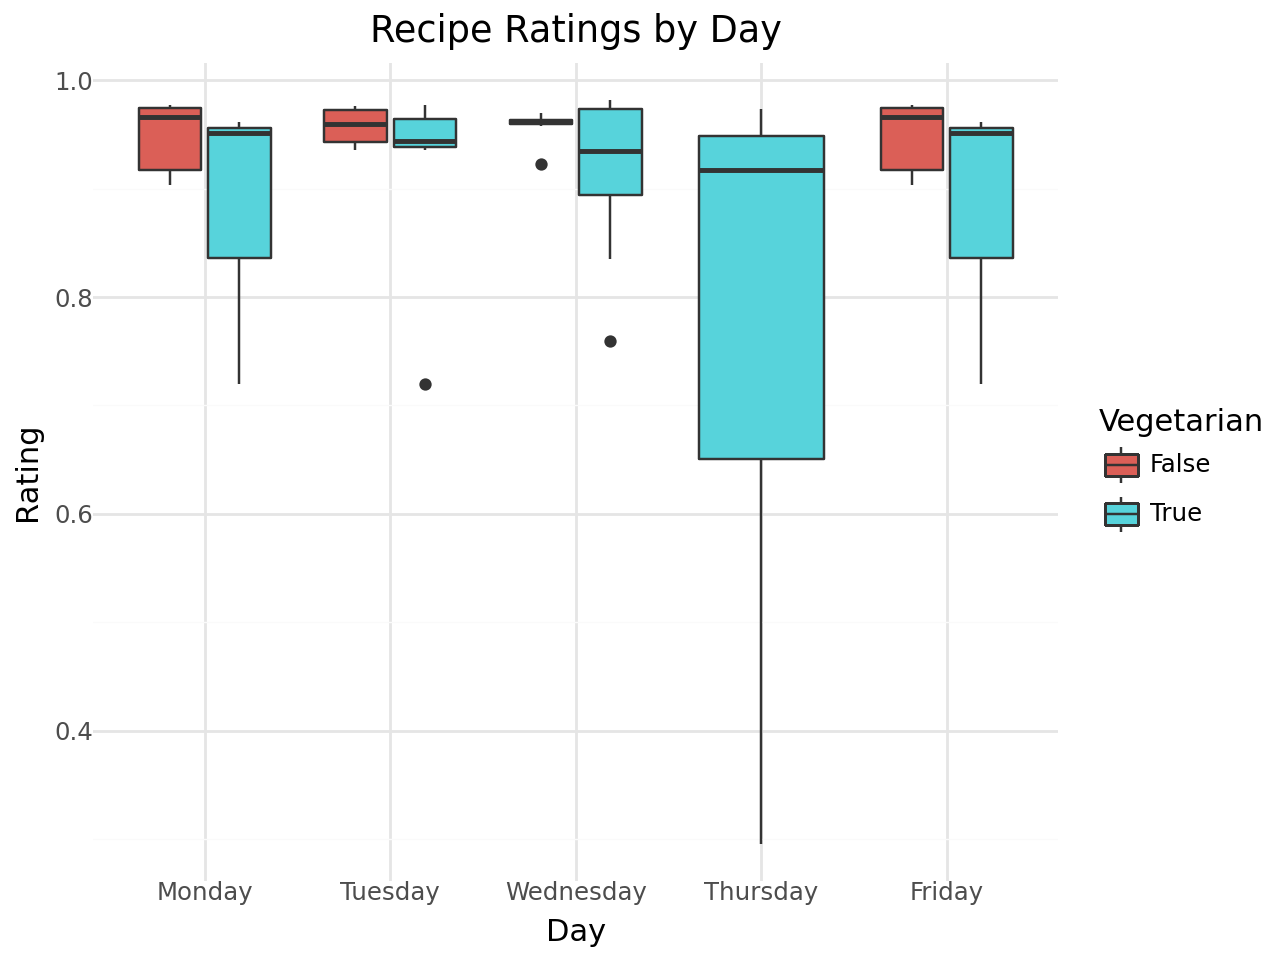

In [ ]:
%matplotlib inline

import pandas as pd
from plotnine import *

# Load data
df = pd.read_csv('mealplan_with_vegetarian.csv')

# Order days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df['Day'] = pd.Categorical(df['Day'], categories=day_order, ordered=True)

# Create plot
plot = (
    ggplot(df, aes(x='Day', y='Rating', fill='Vegetarian')) +
    geom_boxplot() +
    labs(title='Recipe Ratings by Day', x='Day', y='Rating') +
    theme_minimal()
)

plot

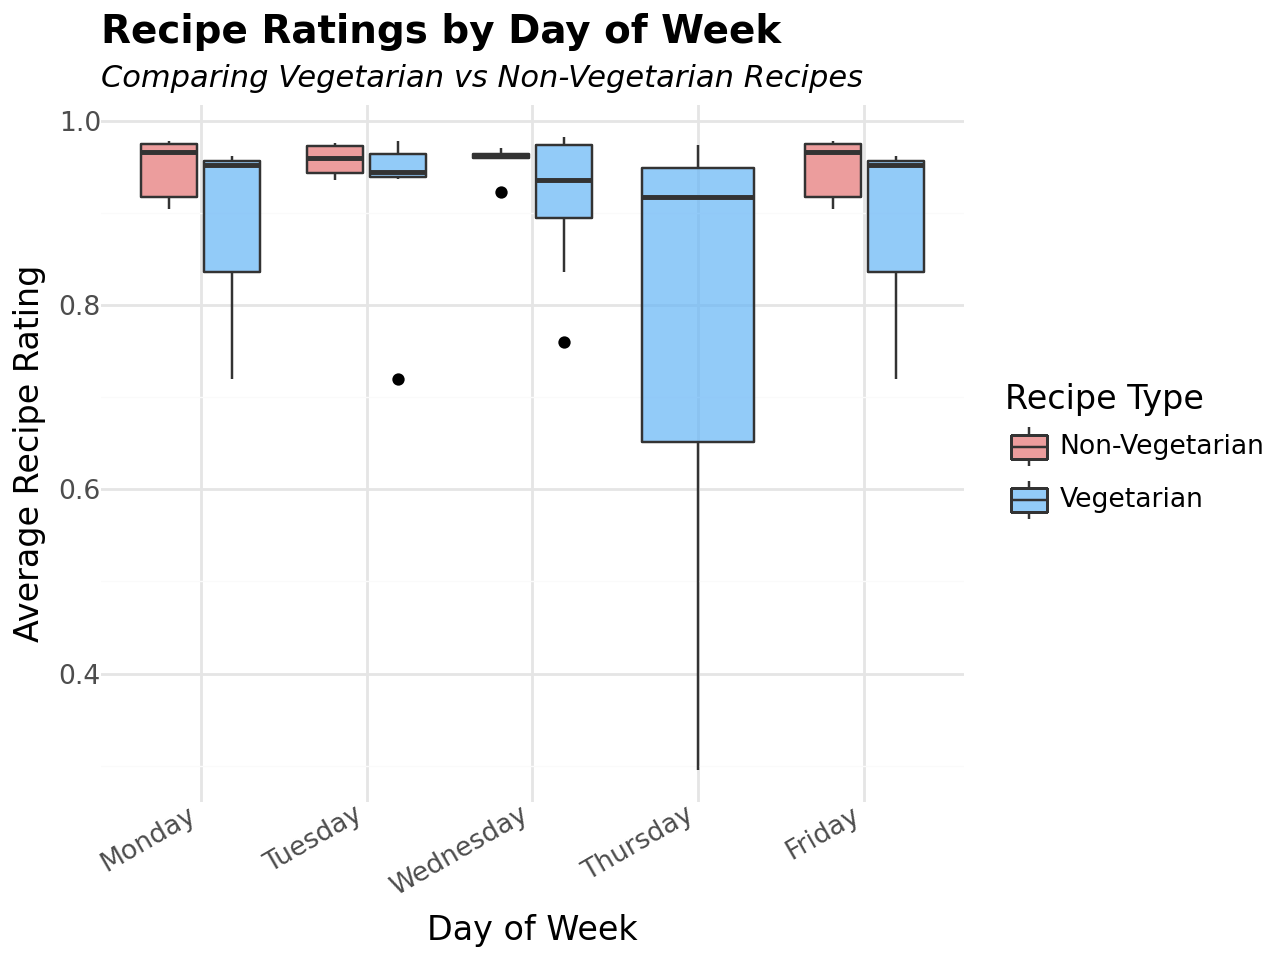

In [ ]:
# Import libraries
import pandas as pd
from plotnine import *

# Load dataset
df = pd.read_csv('mealplan_with_vegetarian.csv')

# Define and order days for consistent plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df['Day'] = pd.Categorical(df['Day'], categories=day_order, ordered=True)

# Create a more interpretable plot
plot = (
    ggplot(df, aes(x='Day', y='Rating', fill='Vegetarian')) +

    # Use boxplot to show rating distribution per day
    geom_boxplot(outlier_color='black', outlier_shape='o', alpha=0.7) +

    # Add labels and title
    labs(
        title='Recipe Ratings by Day of Week',
        subtitle='Comparing Vegetarian vs Non-Vegetarian Recipes',
        x='Day of Week',
        y='Average Recipe Rating',
        fill='Recipe Type'  # Legend label
    ) +

    # Clean minimal theme
    theme_minimal(base_size=12) +

    # Rotate x labels for readability
    theme(
        axis_text_x=element_text(rotation=30, ha='right'),
        plot_title=element_text(size=14, weight='bold'),
        plot_subtitle=element_text(size=11, style='italic')
    ) +

    # Use a more intuitive color palette
    scale_fill_manual(
        values=['#E57373', '#64B5F6'],
        labels=['Non-Vegetarian', 'Vegetarian']
    )
)

# Display the plot
plot
